基于序列可能性定义重要性比率，实际上是调和比例。当 $\pi_{\theta}$ 不断累积并一直大于 $\pi_{\theta_{old}}$ 时，重要性比例会随着输出的长度增加而趋向于减少到 1，但总归仍是大于 1 的；反之亦然。这一项考虑了过去所有 token 重要性系数的调和，所以是 sequence level 的。

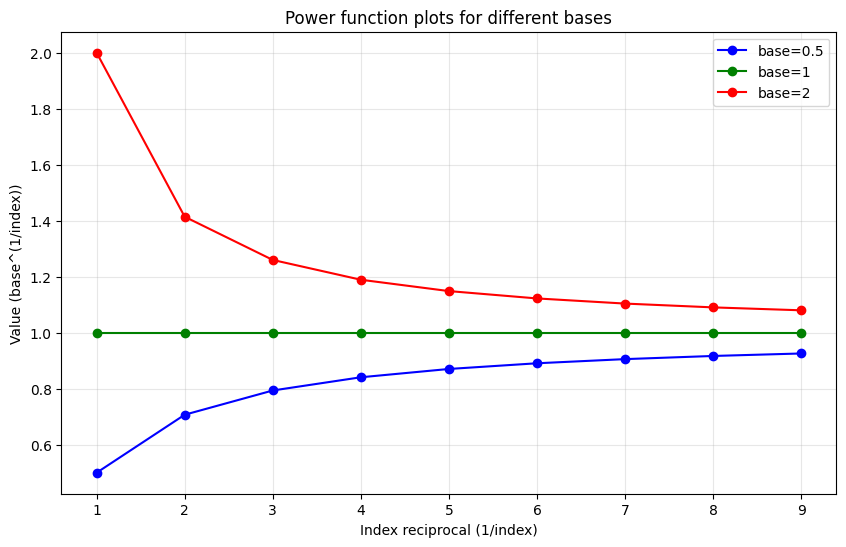

In [12]:
import math
math.sqrt(2) == math.pow(2, 1/2)
import matplotlib.pyplot as plt
import numpy as np

# Generate data
bases = [1/2, 1, 2]
indices = range(1, 10)
colors = ['blue', 'green', 'red']
labels = ['base=0.5', 'base=1', 'base=2']

plt.figure(figsize=(10, 6))

for i, base in enumerate(bases):
    values = [math.pow(base, 1/index) for index in indices]
    plt.plot(indices, values, marker='o', color=colors[i], label=labels[i])

plt.xlabel('Index reciprocal (1/index)')
plt.ylabel('Value (base^(1/index))')
plt.title('Power function plots for different bases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()